In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from numpy.linalg import svd
import scipy
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import sys
from joblib import Parallel, delayed
import tempfile
import os
from joblib import load, dump
import gc
from nltk.corpus import stopwords 
import time
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [69]:
vocabulary_path = '/home/ubuntu/hybrid/vocabulary_8000.txt'

In [70]:
def load_word_vectors(vocabulary_path):
    with open(vocabulary_path) as f:
        vocabulary = [x.strip() for x in f]
    return vocabulary

In [57]:
print ('Data sets:')
    
categories = None             
twenty_train = fetch_20newsgroups(subset='train',
                categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test',
                    categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
data = {
    'x_train': twenty_train['data'],
    'x_test': twenty_test['data'],
    'y_train': twenty_train['target'],
    'y_test': twenty_test['target']
}
stop_words = stopwords.words("english")
vocabulary = load_word_vectors(vocabulary_path)
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                       vocabulary=vocabulary)
vectors = vectorizer.fit_transform(twenty_train.data)
vectors_test = vectorizer.transform(twenty_test.data)

print ('Train:',vectors.shape)
print ('Test:',vectors_test.shape)

In [71]:
vectors.data.nbytes/1024**2

4.532012939453125

In [72]:
with open('output_validate.txt', 'a') as file:
    file.write(cap.stdout)

## LSI

In [105]:
def tr_svd(X, n_comp):
    U, S, Vh = scipy.sparse.linalg.svds(X, n_comp)
    S = np.diag(S[::-1])
    U = U[:, ::-1]
    Vh = Vh[::-1,:]
    return U, S, Vh


def check_ordinary_SVD(X_train, X_test, y_train, components_list, clf, folding_in_flag=True):
    predictions = []
    max_components = max(components_list)
    if folding_in_flag:
        U_train, Sigma, VT = tr_svd(X_train,  max_components)
        U_test_Sigma = X_test @ VT.T
    else:
        X = scipy.sparse.vstack([X_train.toarray(), X_test.toarray()])
        print('computing tr_svd for SVD')
        U, Sigma, VT = tr_svd(X,  max_components)
        print('ended computing tr_svd for SVD')
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    for n_comps in components_list:
        U_train_cut = U_train[:,:n_comps]
        Sigma_cut = Sigma[:n_comps, :n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        clf.fit(U_train_cut @ Sigma_cut, y_train)
        predictions.append(clf.predict(U_test_Sigma_cut))
    print()
    return predictions

In [10]:
print ('Ordinary_LSI')

    
components_list = [100,200,300,1000]
clf = LinearSVC()
pred = check_ordinary_SVD(vectors, vectors_test,twenty_train.target ,
                          components_list=components_list, clf=clf, folding_in_flag=True)


for k,j in enumerate(components_list):
    print (j,' --->\n Accuracy=',metrics.accuracy_score(twenty_test.target, pred[k]),
                   '\n Precision=',metrics.precision_score(twenty_test.target, pred[k], average='weighted'),
                   '\n Recall=',metrics.recall_score(twenty_test.target, pred[k], average='weighted'),
                    '\n F1 score=',metrics.f1_score(twenty_test.target, pred[k], average='weighted'),'\n')

## Local Weighted LSI

In [369]:
def f(rs, a,b):
    return 1/(1+np.exp(-a*(rs+b)))

def fit_predict_class_c(X_train, y_train, X_test, class_c, n_comp,initial_clf, 
                        real_clf, a=2, b=0.1, gamma_size = 1.5):
    indices = np.where(y_train == class_c)[0]
    n = int(len(indices)*gamma_size)
    y_train_transformed = np.zeros_like(y_train)
    y_train_transformed[indices] = 1
    initial_clf.fit(X_train,y_train_transformed)
    initial_relevancy = initial_clf.decision_function(X_train)
    relevancy =  f(initial_relevancy,a,b)
    X_train = (X_train.T @ scipy.sparse.csr_matrix(np.diag(relevancy))).T
    
    space_indices = relevancy.argsort()[-n:][::-1]
    non_space_indices = relevancy.argsort()[:-n][::-1]
    X_1 = X_train[space_indices]
    X_2 = X_train[non_space_indices]
    y_1 = y_train_transformed[space_indices]
    y_2 = y_train_transformed[non_space_indices]
    if (n_comp<min(X_1.shape)):
        u,s,vh = tr_svd(X_1, n_comp)
    else:
        u,s,vh = tr_svd(X_1, min(X_1.shape)-1)  
    X_1_transformed = u @ s
    X_2_transformed = X_2 @ vh.T 
    X = np.vstack((X_1_transformed, X_2_transformed))
    y = np.hstack((y_1, y_2))
    
    rel_for_test = f(initial_clf.predict(X_test),a,b)
    
    X_test = (X_test.T@np.diag(rel_for_test)).T
    X_test_transformed = X_test @ vh.T

    real_clf.fit(X, y)
    decisions = real_clf.decision_function(X_test_transformed)
    return decisions

def dec_append(decisions,X_train, y_train,X_test,class_c,
                                             n_comp,initial_clf, real_clf, a,b,gamma_size):
    decisions[class_c] = fit_predict_class_c(X_train, y_train,X_test,class_c,
                                             n_comp,initial_clf, real_clf, a,b)

def fit_predict(X_train, y_train,X_test,n_comp,initial_clf, real_clf, a,b,gamma_size):
    n_classes = max(y_train)+1
    decisions = []

    for i in range(n_classes):
        decisions.append(fit_predict_class_c(X_train, y_train,X_test,class_c = i,
                                            n_comp=n_comp,initial_clf=initial_clf, 
                                             real_clf=real_clf, a=a,b=b,gamma_size=gamma_size))
    decisions = np.vstack(decisions)
    pred = decisions.argmax(axis=0) 
    return pred

Подбор a,b,gamma в Local

In [112]:
x_train, x_validate, y_train, y_validate = train_test_split(vectors, twenty_train.target, 
                                                            test_size = 0.25, random_state =42)
initial_clf = LinearSVC(C=0.1)
real_clf = LinearSVC(C = 1)
n_comp = 100

In [370]:
def res_append(X_train, y_train,X_test, y_test,n_comp,initial_clf, real_clf, a_s,b_s,gamma_size):
    results = {}
    for a in a_s:
        for b in b_s:
            t0 = time.time()
            pred = fit_predict(X_train, y_train,X_test,n_comp,initial_clf, real_clf, a,b,gamma_size)
            print (gamma_size, ' ' , a, ' ', b, '---->F1 score=',metrics.f1_score(y_test, pred, average='weighted'), \
                   'time passed: ', time.time() - t0,'\n')
            results[(a, b)] = pred
    return results

In [372]:
a_params = [2,3,5]
b_params = [0,0.5,0.8, 1, 1.2, 1.5, 2] 
gamma_params = [1.2, 2, 3, 5, 10]
results = Parallel(n_jobs=4)(delayed(res_append)(x_train, y_train,x_validate, y_validate,
                                      n_comp = 100,initial_clf=initial_clf, real_clf=real_clf,
                                      a_s = a_params, b_s = b_params, gamma_size = g) for g in gamma_params)

1.2   2   0 ---->F1 score= 0.669063209156 time passed:  50.14198040962219 

2   2   0 ---->F1 score= 0.663864780338 time passed:  52.96290397644043 

3   2   0 ---->F1 score= 0.663285490642 time passed:  53.58087635040283 

5   2   0 ---->F1 score= 0.66196288407 time passed:  56.36155080795288 

1.2   2   0.5 ---->F1 score= 0.681695101626 time passed:  52.78082084655762 

2   2   0.5 ---->F1 score= 0.682565767247 time passed:  52.1256947517395 

3   2   0.5 ---->F1 score= 0.683705001362 time passed:  52.634443044662476 

5   2   0.5 ---->F1 score= 0.684263293563 time passed:  56.35069465637207 

1.2   2   0.8 ---->F1 score= 0.68332943624 time passed:  51.464831829071045 

2   2   0.8 ---->F1 score= 0.685177639934 time passed:  54.23587417602539 

3   2   0.8 ---->F1 score= 0.686051491307 time passed:  53.171690702438354 

5   2   0.8 ---->F1 score= 0.683731748217 time passed:  55.91598320007324 

1.2   2   1 ---->F1 score= 0.676997895583 time passed:  50.228981256484985 

2   2   1 ---

In [ ]:
for (a,b),val  in results[0].items():
    print (a,b,' --->\n Accuracy=',metrics.accuracy_score(y_validate, val),
                   '\n Precision=',metrics.precision_score(y_validate, val, average='weighted'),
                   '\n Recall=',metrics.recall_score(y_validate, val, average='weighted'),
                    '\n F1 score=',metrics.f1_score(y_validate, val, average='weighted'),'\n')

In [374]:
RES= []
for gamma_ind in range(len(gamma_params)):
    k = []
    for a in a_params:
        l =[]
        for b in b_params:
            pred = results[gamma_ind][(a,b)]
            res = metrics.f1_score(y_validate, pred, average='weighted')
            l.append(res)
        k.append(l)
    RES.append(k)   

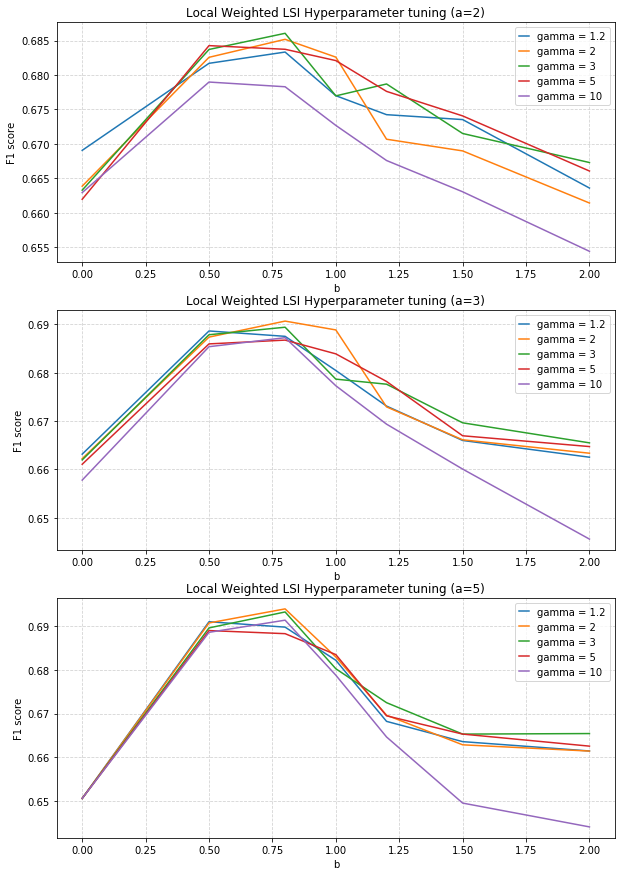

In [399]:
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(10,15))

for i, ax in enumerate(axes.flat):
    for gamma_in in range(len(gamma_params)):
        ax.plot(b_params, RES[gamma_in][i],
                 label ='gamma = {}'.format(gamma_params[gamma_in]))
    ax.grid(color='lightgray', linestyle='dashed')
    ax.set_title('Local Weighted LSI Hyperparameter tuning (a={})'.format(a_params[i]))
    ax.set_xlabel('b')
    ax.set_ylabel('F1 score')
    ax.legend()
plt.savefig("Weighted_hyperparameters.eps", bbox_inches='tight')
plt.show()

a = 5
b = 0.8
gamma = 2

In [144]:
for (a,b),val  in results[1].items():
    print (a,b,' --->\n Accuracy=',metrics.accuracy_score(y_validate, val),
                   '\n Precision=',metrics.precision_score(y_validate, val, average='weighted'),
                   '\n Recall=',metrics.recall_score(y_validate, val, average='weighted'),
                    '\n F1 score=',metrics.f1_score(y_validate, val, average='weighted'),'\n') 

2 0  --->
 Accuracy= 0.674443266172 
 Precision= 0.687070038318 
 Recall= 0.674443266172 
 F1 score= 0.6774602213 

2 0.2  --->
 Accuracy= 0.675503711559 
 Precision= 0.686185273126 
 Recall= 0.675503711559 
 F1 score= 0.678771723458 

2 0.4  --->
 Accuracy= 0.677271120537 
 Precision= 0.686001207188 
 Recall= 0.677271120537 
 F1 score= 0.680342650178 

2 0.8  --->
 Accuracy= 0.679745493107 
 Precision= 0.681547308866 
 Recall= 0.679745493107 
 F1 score= 0.677183984118 

3 0  --->
 Accuracy= 0.648639095087 
 Precision= 0.688082254397 
 Recall= 0.648639095087 
 F1 score= 0.657658954082 

3 0.2  --->
 Accuracy= 0.656062212796 
 Precision= 0.684740968276 
 Recall= 0.656062212796 
 F1 score= 0.662023793089 

3 0.4  --->
 Accuracy= 0.669848002828 
 Precision= 0.687790415849 
 Recall= 0.669848002828 
 F1 score= 0.674581783303 

3 0.8  --->
 Accuracy= 0.675857193355 
 Precision= 0.678000392675 
 Recall= 0.675857193355 
 F1 score= 0.673891149339 

5 0  --->
 Accuracy= 0.641215977377 
 Precisio

Подбор С в Real_clf

In [376]:
x_train, x_validate, y_train, y_validate = train_test_split(vectors, twenty_train.target, 
                                                            test_size = 0.25, random_state =42)
initial_clf = LinearSVC(C=0.1)
real_clf = LinearSVC(C = 1)
components_list = [10,50, 100,300,500]
c_params = [0.01, 0.1, 1, 10, 100]

In [379]:
def res_append_C(X_train, y_train,X_test, y_test,component_list,initial_clf, c, a,b,gamma_size):
    results = {}
    for n_comp in component_list:
        real_clf = LinearSVC(C = c)
        t0 = time.time()
        pred = fit_predict(X_train, y_train,X_test,n_comp,initial_clf, real_clf, a,b,gamma_size)
        print (c, n_comp, '---->F1 score=',metrics.f1_score(y_test, pred, average='weighted'), \
                   'time passed: ', time.time() - t0,'\n')
        results[n_comp] = pred
    return results

In [380]:
results_c = Parallel(n_jobs=5)(delayed(res_append_C)(x_train, y_train,x_validate, y_validate,
                                      components_list,initial_clf,c,a =5, b=0.8,gamma_size = 2)
                               for c in c_params)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01 10 ---->F1 score= 0.612978036042 time passed:  44.69494962692261 

10 10 ---->F1 score= 0.61301715923 time passed:  45.2629930973053 
1 10 ---->F1 score= 0.625989982456 time passed:  45.267507553100586 


0.1 10 ---->F1 score= 0.653528267838 time passed:  46.23290228843689 

100 10 ---->F1 score= 0.609941825466 time passed:  60.05275774002075 

0.01 50 ---->F1 score= 0.632639435334 time passed:  51.134180545806885 

0.1 50 ---->F1 score= 0.680069206753 time passed:  49.85846471786499 

1 50 ---->F1 score= 0.655470943087 time passed:  51.689494132995605 

10 50 ---->F1 score= 0.643156740027 time passed:  60.82332801818848 

0.01 100 ---->F1 score= 0.638885116891 time passed:  55.933239698410034 

0.1 100 ---->F1 score= 0.693967594687 time passed:  58.3392550945282 

100 50 ---->F1 score= 0.635688275727 time passed:  95.28901696205139 

1 100 ---->F1 score= 0.659818673949 time passed:  60.900017976760864 

10 100 ---->F1 score= 0.639756047175 time passed:  74.99649310112 

0.1 300 -

In [381]:
results_c

[{10: array([ 1,  6,  3, ...,  1, 17,  3]),
  50: array([ 1,  6,  3, ...,  1, 17,  3]),
  100: array([ 1,  6,  3, ...,  1, 17,  3]),
  300: array([ 1,  6,  3, ...,  1, 17,  3]),
  500: array([ 3,  6,  3, ...,  1, 17,  3])},
 {10: array([12,  6,  3, ...,  1, 17,  3]),
  50: array([13,  6,  3, ...,  1, 17,  3]),
  100: array([13,  6,  6, ...,  1, 17,  3]),
  300: array([ 3,  6,  6, ...,  1, 17,  3]),
  500: array([ 3,  6,  6, ...,  1, 17,  3])},
 {10: array([ 8,  6,  3, ...,  1, 17,  3]),
  50: array([13,  6,  4, ...,  1, 17,  3]),
  100: array([13,  6,  6, ...,  1, 17,  3]),
  300: array([ 3,  6,  6, ...,  1, 17,  3]),
  500: array([ 3,  6,  6, ...,  1, 17,  3])},
 {10: array([ 8,  6,  3, ...,  1, 17,  3]),
  50: array([13,  6,  4, ...,  1, 17,  3]),
  100: array([13,  6,  6, ...,  1, 17,  3]),
  300: array([ 3,  6,  6, ...,  1, 17,  3]),
  500: array([14,  6,  6, ...,  1, 17,  3])},
 {10: array([ 8,  6,  3, ...,  1, 17,  3]),
  50: array([13,  6,  4, ...,  1, 17,  3]),
  100: array([13

In [382]:
RES_C = []
for n_comp in components_list:
    l =[]
    for n,c in enumerate(c_params):
        pred = results_c[n][n_comp]
        res = metrics.f1_score(y_validate, pred, average='weighted')
        l.append(res)
    RES_C.append(l)      

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [383]:
RES_C

[[0.61297803604206247,
  0.65352826783757756,
  0.62598998245580606,
  0.61301715923013822,
  0.6099418254662291],
 [0.63263943533447031,
  0.68006920675348448,
  0.65547094308683174,
  0.64315674002672607,
  0.63568827572713182],
 [0.63888511689067118,
  0.69396759468727476,
  0.65981867394945581,
  0.63975604717531609,
  0.63360014934027331],
 [0.64948525667641677,
  0.70532935695754584,
  0.68521341530943158,
  0.64220009946355616,
  0.60795709044522928],
 [0.65659534796401053,
  0.71390695433095386,
  0.68801502119773206,
  0.63218679277733592,
  0.59837000996030698]]

In [2]:
plt.figure(figsize=(10,6))
for n,n_comp in enumerate(components_list):
    plt.semilogx(c_params, RES_C[n],label ='N_comp = {}'.format(n_comp))
        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Real classifier Hyperparameter tuning')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('F1 score')
plt.savefig("Local_grid_search_C.eps", bbox_inches='tight')
plt.show()

NameError: name 'components_list' is not defined

#### Local LSI (RDS)

In [385]:
def fit_predict_class_c_local(X_train, y_train, X_test, class_c, n_comp,real_clf):
    space_indices = np.where(y_train == class_c)[0]
    non_space_indices = np.where(y_train != class_c)[0]
    y_train_transformed = np.zeros_like(y_train)
    y_train_transformed[space_indices] = 1
    X_1 = X_train[space_indices]
    X_2 = X_train[non_space_indices]
    y_1 = y_train_transformed[space_indices]
    y_2 = y_train_transformed[non_space_indices]
    if (n_comp<min(X_1.shape)):
        u,s,vh = tr_svd(X_1, n_comp)
    else:
        u,s,vh = tr_svd(X_1, min(X_1.shape)-1) 
    X_1_transformed = u @ s
    X_2_transformed = X_2 @ vh.T 
    X = np.vstack((X_1_transformed, X_2_transformed))
    y = np.hstack((y_1, y_2))
    X_test_transformed = X_test @ vh.T

    real_clf.fit(X, y)
    decisions = real_clf.decision_function(X_test_transformed)
    return decisions

def fit_predict_local(X_train, y_train,X_test,n_comp,real_clf):
    n_classes = max(y_train)+1
    decisions = []
    for i in range(n_classes):
        decisions.append(fit_predict_class_c_local(X_train, y_train,X_test,class_c = i,
                                            n_comp=n_comp, real_clf=real_clf))
    decisions = np.vstack(decisions)
    pred = decisions.argmax(axis=0) 
    return pred

In [386]:
def res_append_C_local(X_train, y_train,X_test, y_test,component_list,c):
    results = {}
    for n_comp in component_list:
        real_clf = LinearSVC(C = c)
        t0 = time.time()
        pred = fit_predict_local(X_train, y_train,X_test,n_comp,real_clf)
        print (c, ' ' , n_comp, '---->F1 score=',metrics.f1_score(y_test, pred, average='weighted'), \
                   'time passed: ', time.time() - t0,'\n')
        results[n_comp] = pred
    return results

In [ ]:
results_c_local = Parallel(n_jobs=5)(delayed(res_append_C_local)(x_train, y_train,x_validate, y_validate,
                                      components_list,c)for c in c_params)

0.1   10 ---->F1 score= 0.601322004665 time passed:  2.0177955627441406 

0.01   10 ---->F1 score= 0.572790260967 time passed:  2.933631658554077 

1   10 ---->F1 score= 0.602565086417 time passed:  3.809715986251831 

0.1   50 ---->F1 score= 0.649808798184 time passed:  7.6090357303619385 

0.01   50 ---->F1 score= 0.604805787276 time passed:  6.987355947494507 

10   10 ---->F1 score= 0.601552358786 time passed:  12.448758602142334 

1   50 ---->F1 score= 0.647540155842 time passed:  9.803342580795288 

0.01   100 ---->F1 score= 0.618455921693 time passed:  13.37402892112732 

0.1   100 ---->F1 score= 0.651457908297 time passed:  14.087201118469238 

1   100 ---->F1 score= 0.659454886627 time passed:  15.240354537963867 

100   10 ---->F1 score= 0.600624380738 time passed:  30.976375102996826 

10   50 ---->F1 score= 0.647439052813 time passed:  32.879523277282715 

0.01   300 ---->F1 score= 0.635461513829 time passed:  22.93606424331665 

0.1   300 ---->F1 score= 0.675042984275 time

In [259]:
results_c_local

[{10: array([ 1, 14,  3, ..., 14, 17,  3]),
  50: array([ 6, 14,  3, ...,  1, 17,  3]),
  100: array([ 1, 14,  3, ...,  1, 17,  3]),
  300: array([ 1, 14,  3, ...,  1, 17,  3]),
  500: array([ 1, 14,  3, ...,  1, 17,  3])},
 {10: array([ 0, 14,  3, ...,  1, 17,  3]),
  50: array([ 0, 14,  3, ...,  1, 17,  3]),
  100: array([ 3, 14,  3, ...,  1, 17,  3]),
  300: array([14, 14,  3, ...,  1, 17,  3]),
  500: array([ 3, 14,  3, ...,  1, 17,  3])},
 {10: array([ 0, 14,  3, ...,  1, 17,  3]),
  50: array([ 0, 14,  3, ...,  1, 17,  3]),
  100: array([ 3, 14,  3, ...,  1, 17,  3]),
  300: array([14,  3,  4, ...,  1, 17,  3]),
  500: array([17,  6,  4, ...,  1, 17,  3])},
 {10: array([ 0, 14,  3, ...,  1, 17,  3]),
  50: array([ 0, 14,  3, ...,  1, 17,  3]),
  100: array([ 3,  6,  3, ...,  1, 17,  3]),
  300: array([14,  3,  4, ...,  1, 17,  3]),
  500: array([17,  6,  4, ...,  1, 17,  3])},
 {10: array([ 0, 14,  3, ...,  1, 17,  3]),
  50: array([ 0, 14,  3, ...,  1, 17,  3]),
  100: array([ 3

In [260]:
RES_C_local = []
for n_comp in components_list:
    l =[]
    for n,c in enumerate(c_params):
        pred = results_c_local[n][n_comp]
        res = metrics.f1_score(y_validate, pred, average='weighted')
        l.append(res)
    RES_C_local.append(l)      

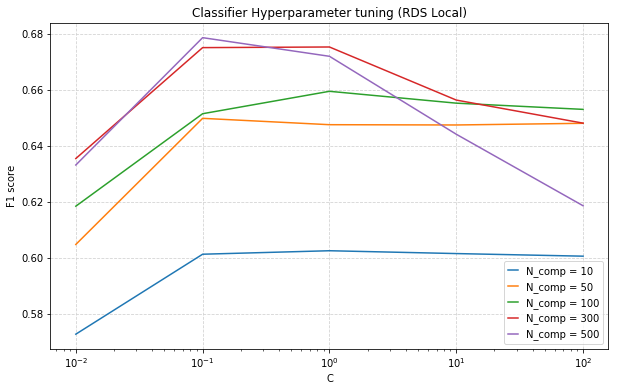

In [397]:
plt.figure(figsize=(10,6))
for n,n_comp in enumerate(components_list):
    plt.semilogx(c_params, RES_C_local[n],label ='N_comp = {}'.format(n_comp))
        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Classifier Hyperparameter tuning (RDS Local)')
plt.legend()
plt.xlabel('C')
plt.ylabel('F1 score')
plt.savefig("Local_grid_search_C_RDS.eps", bbox_inches='tight')
plt.show()

#### RDS Local for full dataset

In [387]:
print (vectors.shape)
print (twenty_train.target.shape)
print (vectors_test.shape)

(11314, 7652)
(11314,)
(7532, 7652)


In [388]:
components_list_final = [3, 8, 13, 20, 50, 100, 200, 300, 500, 700, 1000]
c = 0.1
real_clf = LinearSVC(C = c)

In [267]:
def Compute_Local_RDS_full(n_comp):
    t0 = time.time()
    pred = fit_predict_local(vectors, twenty_train.target, vectors_test,n_comp,real_clf)
    print (n_comp, 'time passed: ', time.time() - t0,'\n')
    return pred

In [268]:
results_RDS_full = Parallel(n_jobs=4)(delayed(Compute_Local_RDS_full)(n_comp)for n_comp in components_list_final)

3 time passed:  2.403447151184082 

8 time passed:  2.9081902503967285 

13 time passed:  4.148610353469849 

20 time passed:  5.44898533821106 

50 time passed:  8.514430522918701 

100 time passed:  15.526836156845093 

200 time passed:  28.583847045898438 

300 time passed:  34.18579626083374 

500 time passed:  41.58719229698181 

700 time passed:  61.12563157081604 

1000 time passed:  53.89956569671631 



In [293]:
results_RDS_full

[array([ 4,  1, 19, ...,  9,  3, 15]),
 array([ 4,  1, 19, ..., 10,  3, 15]),
 array([ 7,  1, 19, ...,  9,  3, 15]),
 array([ 4,  1, 15, ...,  9,  3, 15]),
 array([ 4,  1, 15, ...,  9,  3, 15]),
 array([ 4,  1, 15, ...,  9,  3, 15]),
 array([ 4,  5, 15, ...,  9,  3, 15]),
 array([ 4,  5,  8, ...,  9,  3, 15]),
 array([ 4,  1,  0, ...,  9,  3, 15]),
 array([ 4,  1,  0, ...,  9,  3, 15]),
 array([ 4,  1,  0, ...,  9,  3, 15])]

In [294]:
RESULTS_FINAL_RDS =[]
f1_scores =[]
precisions = []
recalls =[]
accuracies = []
for n in range(len(components_list_final)):
    pred = results_RDS_full[n]
    f1_scores.append(metrics.f1_score(twenty_test.target, pred, average='weighted'))
    precisions.append(metrics.precision_score(twenty_test.target, pred, average='weighted'))
    recalls.append(metrics.recall_score(twenty_test.target, pred, average='weighted'))
    accuracies.append(metrics.accuracy_score(twenty_test.target, pred))
RESULTS_FINAL_RDS.append(f1_scores)
RESULTS_FINAL_RDS.append(precisions)
RESULTS_FINAL_RDS.append(recalls)
RESULTS_FINAL_RDS.append(accuracies)    

In [295]:
RESULTS_FINAL_RDS

[[0.57682528761240492,
  0.57740595682926499,
  0.57475666532301217,
  0.57949905240080046,
  0.59908695498437947,
  0.60087815990088467,
  0.60975849400746396,
  0.61619641261642699,
  0.62651444744006002,
  0.62914880277070917,
  0.62914880277070917],
 [0.59274957022195451,
  0.58844834160989878,
  0.58500308999792938,
  0.58580069630437848,
  0.60638541828875103,
  0.61048713232664287,
  0.61948668387985761,
  0.62521758858564225,
  0.63480400013519556,
  0.63824470747238393,
  0.63824470747238393],
 [0.57580987785448756,
  0.57727031332979284,
  0.57554434413170474,
  0.58085501858736055,
  0.59944237918215615,
  0.60793945831120555,
  0.61630377057886354,
  0.62294211364843333,
  0.63316516197557093,
  0.6360860329261816,
  0.6360860329261816],
 [0.57580987785448756,
  0.57727031332979284,
  0.57554434413170474,
  0.58085501858736055,
  0.59944237918215615,
  0.60793945831120555,
  0.61630377057886354,
  0.62294211364843333,
  0.63316516197557093,
  0.6360860329261816,
  0.6360860

#### Local Weighted for full dataset

In [389]:
initial_clf = LinearSVC(C=0.1)
c = 0.1
real_clf = LinearSVC(C=c)
a = 5
b = 0.8
gamma = 2

In [390]:
def Compute_Local_Weighted_full(n_comp):
    t0 = time.time()
    pred = fit_predict(vectors, twenty_train.target, vectors_test,n_comp,initial_clf,real_clf,a,b,gamma)
    print (n_comp, 'time passed: ', time.time() - t0,'\n')
    return pred

In [391]:
results_Weighted_full = Parallel(n_jobs=8)(delayed(Compute_Local_Weighted_full)(n_comp)
                                           for n_comp in components_list_final)

8 time passed:  238.35131788253784 

3 time passed:  243.2310082912445 

13 time passed:  247.34419465065002 

20 time passed:  247.9517307281494 

50 time passed:  255.8173530101776 

100 time passed:  272.2589225769043 

200 time passed:  290.8771598339081 

300 time passed:  310.1478657722473 

500 time passed:  227.2973608970642 

700 time passed:  246.51077938079834 

1000 time passed:  262.2774040699005 



In [392]:
results_Weighted_full

[array([ 7,  8, 19, ...,  9, 12, 15]),
 array([ 7,  8,  0, ..., 10,  3, 15]),
 array([ 7,  1, 19, ...,  9,  3, 15]),
 array([ 7,  1, 15, ...,  9,  3, 15]),
 array([ 4,  1, 15, ...,  9,  3, 15]),
 array([ 4,  1, 19, ...,  9,  6, 15]),
 array([ 4,  1,  2, ..., 10,  6, 15]),
 array([ 4,  1,  2, ...,  9,  6, 15]),
 array([ 4,  1, 19, ...,  9,  6, 15]),
 array([ 4,  1, 19, ...,  9, 12, 15]),
 array([ 4,  1, 19, ...,  9, 12, 15])]

In [393]:
RESULTS_FINAL_WEIGHTED =[]
f1_scores =[]
precisions = []
recalls =[]
accuracies = []
for n in range(len(components_list_final)):
    pred = results_Weighted_full[n]
    f1_scores.append(metrics.f1_score(twenty_test.target, pred, average='weighted'))
    precisions.append(metrics.precision_score(twenty_test.target, pred, average='weighted'))
    recalls.append(metrics.recall_score(twenty_test.target, pred, average='weighted'))
    accuracies.append(metrics.accuracy_score(twenty_test.target, pred))
RESULTS_FINAL_WEIGHTED.append(f1_scores)
RESULTS_FINAL_WEIGHTED.append(precisions)
RESULTS_FINAL_WEIGHTED.append(recalls)
RESULTS_FINAL_WEIGHTED.append(accuracies)

In [394]:
RESULTS_FINAL_WEIGHTED

[[0.58402456623826671,
  0.60800952721233337,
  0.61715807790834898,
  0.62019656907891607,
  0.63171379122284499,
  0.63847426721304334,
  0.63701037253548953,
  0.64201279879244211,
  0.64728330553339541,
  0.65200619091579848,
  0.65433524862486991],
 [0.60278876517345581,
  0.61970953726507572,
  0.62668081676600595,
  0.62911564889641625,
  0.63848724719528871,
  0.64490730547741981,
  0.64483940737094081,
  0.64988464095508203,
  0.6544309948323872,
  0.65950705458482861,
  0.66299564111806308],
 [0.58988316516197559,
  0.60979819437068505,
  0.61789697291556023,
  0.62108337758895382,
  0.63210302708443977,
  0.63794476898566121,
  0.64391927774827407,
  0.64843335103558153,
  0.65361125862984604,
  0.65825809877854491,
  0.659984067976633],
 [0.58988316516197559,
  0.60979819437068505,
  0.61789697291556023,
  0.62108337758895382,
  0.63210302708443977,
  0.63794476898566121,
  0.64391927774827407,
  0.64843335103558153,
  0.65361125862984604,
  0.65825809877854491,
  0.6599840

### Comparison

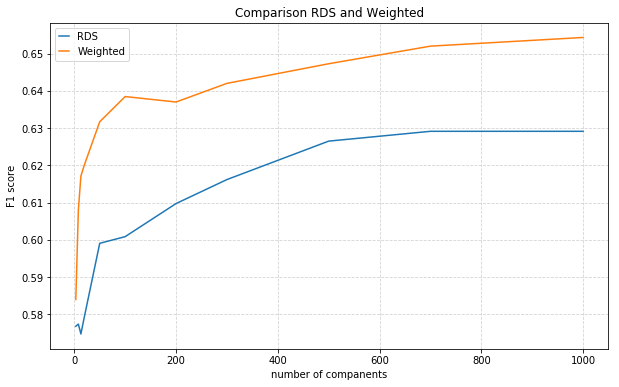

In [395]:
# F1 score
plt.figure(figsize=(10,6))
plt.plot(components_list_final, RESULTS_FINAL_RDS[0],label ='RDS')
plt.plot(components_list_final, RESULTS_FINAL_WEIGHTED[0],label ='Weighted')        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Comparison RDS and Weighted')
plt.legend()
plt.xlabel('number of companents')
plt.ylabel('F1 score')
plt.savefig("F1_RDS_Weighted.eps", bbox_inches='tight')
plt.show()

#### Saving

In [396]:
file_RDS = "saved_RDS.npy"
file_Weighted = "saved_Weighted.npy"
file_scores_RDS = "saved_scores_RDS.npy"
file_scores_Weighted = "saved_scores_Weighted.npy"
np.save(file_RDS, np.array(results_RDS_full))
np.save(file_Weighted, np.array(results_Weighted_full))
np.save(file_scores_RDS, np.array(RESULTS_FINAL_RDS))
np.save(file_scores_Weighted, np.array(RESULTS_FINAL_WEIGHTED))